**Simple Notebook for exploring the data ...**

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
import numpy as np 
import pandas as pd 
from scipy import signal
%matplotlib inline
import matplotlib.pyplot as plt

from src import kagglegym

In [3]:
# This part is going to be for explorind the dataset ...
# so we want the entire dataset ..
with pd.HDFStore("../data/train.h5", "r") as train:
    df = train.get("train")

In [4]:
list(set([c.split('_')[0] for c in df.columns]))

['y', 'id', 'timestamp', 'fundamental', 'technical', 'derived']

So there are three types of main cells. 

 - `timestamp`: current timestamp
 - `y`: This is what we want to predict
 - [`fundamental`, `derived`, `technical`]: these are our predictors

In [5]:
# Finding distributions of the result

df1 = df[['timestamp', 'y']].groupby('timestamp').agg([np.mean, np.std, len]).reset_index()
df1.head()

timestamp         y                 
                 mean       std    len
0         0 -0.001870  0.026646  750.0
1         1  0.000501  0.028422  750.0
2         2 -0.005787  0.029281  750.0
3         3  0.001633  0.025333  750.0
4         4 -0.004309  0.035929  750.0

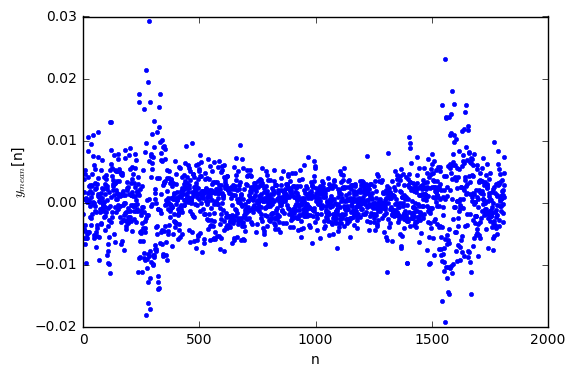

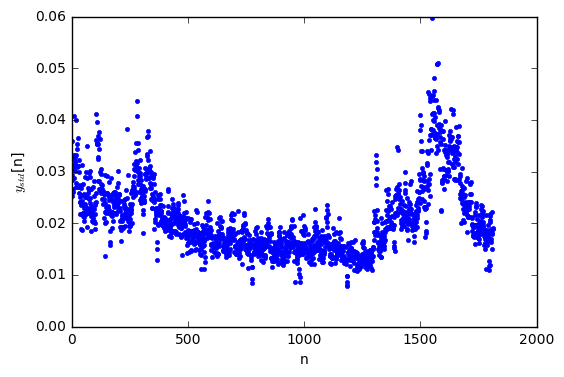

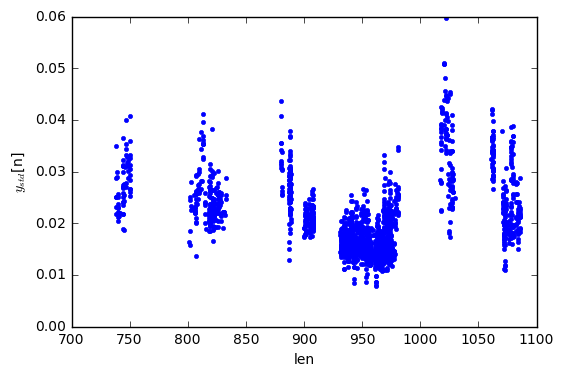

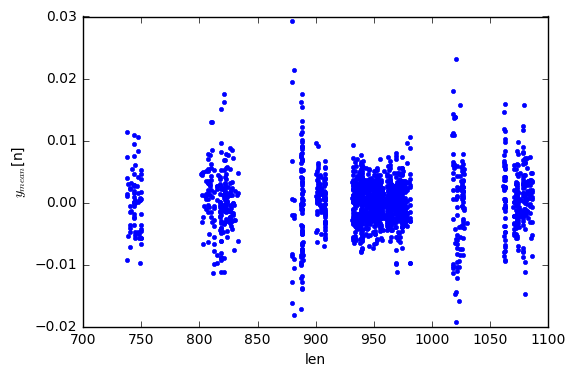

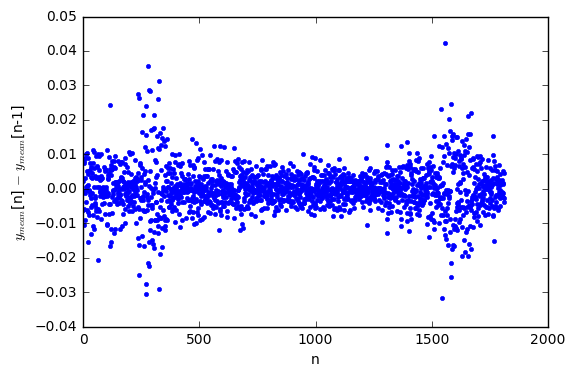

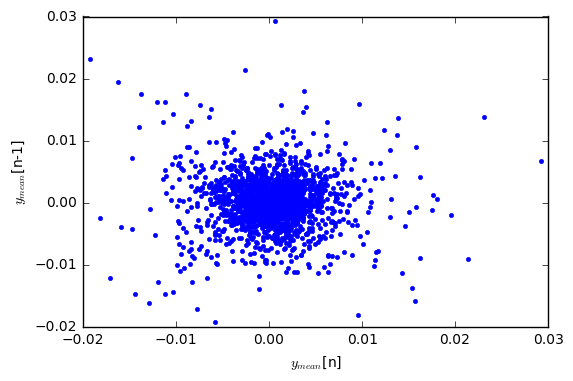

In [8]:
n     = df1['timestamp']
yMean = np.array(df1['y']['mean'])
yStd  = np.array(df1['y']['std'])

plt.figure()
plt.plot(n, yMean, '.')
plt.xlabel('n')
plt.ylabel('$y_{mean}$[n]')

plt.figure()
plt.plot(n, yStd, '.')
plt.xlabel('n')
plt.ylabel('$y_{std}$[n]')

plt.figure()
plt.plot(np.array(df1['y']['len']), yStd, '.')
plt.xlabel('len')
plt.ylabel('$y_{std}$[n]')

plt.figure()
plt.plot(np.array(df1['y']['len']), yMean, '.')
plt.xlabel('len')
plt.ylabel('$y_{mean}$[n]')

plt.figure()
plt.plot(np.diff(yMean), '.')
plt.xlabel('n')
plt.ylabel('$y_{mean}$[n] $-$ $y_{mean}$[n-1]')

plt.figure()
plt.plot( yMean[:-1] , yMean[1:] , '.')
plt.xlabel('$y_{mean}$[n]')
plt.ylabel('$y_{mean}$[n-1]')

Wow, there seems to be absolutely no correlations 

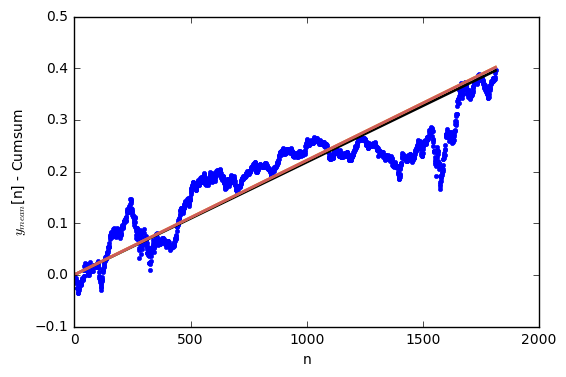

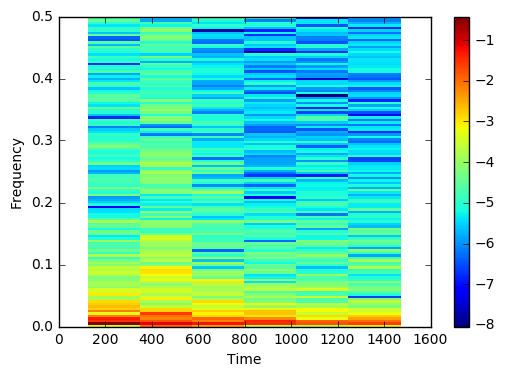

In [9]:
#Calculate running averages ...
#yMeanRA = np.cumsum( yMean )/np.linspace( 1, len(yMean), len(yMean) )
#yStdRA  = np.cumsum( yStd )/np.linspace( 1, len(yMean), len(yMean) )

yMeanCumsum = np.cumsum( yMean )
f, t, Syy   =  signal.spectrogram(yMeanCumsum)

slope1 = np.mean(yMean)
slope2 = np.mean(df['y'])
slope3 = np.mean(df['y'][df.timestamp < 906])

plt.figure()
plt.plot(n, yMeanCumsum, '.')
plt.plot(n, slope1*n, color='black', lw=2 ) 
plt.plot(n, slope2*n, color='orange', lw=2 ) 
plt.plot(n, slope2*n, color='indianred', lw=2 ) 
plt.xlabel('n')
plt.ylabel('$y_{mean}$[n] - Cumsum')

plt.figure()
plt.pcolormesh(t, f, np.log10(Syy))
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.colorbar()

The cumulative sum seems to be increasing linearly. Is there something there??? I need to find a linear trend and see of there is something that can be obtained form there. The linear 

In [10]:
# Remember that the training contains timestamps upto 905
np.mean(yMean), np.mean(df['y']), np.mean(df['y'][df.timestamp < 906])

(0.00021821978, 0.00022174742, 0.00025588431)

This means that the mean of y is greater than zero. This is great. This tells us that the slope overall should be positive. Now, lets find out if we will be able to find significant deviations from the mean. The way we want to check is to see of the standard deviations for a day is a meaningful measure of predicting deviations from the mean ...

The following calculations are not realistic because we have a *look-ahead bias*. But right now we don't care.

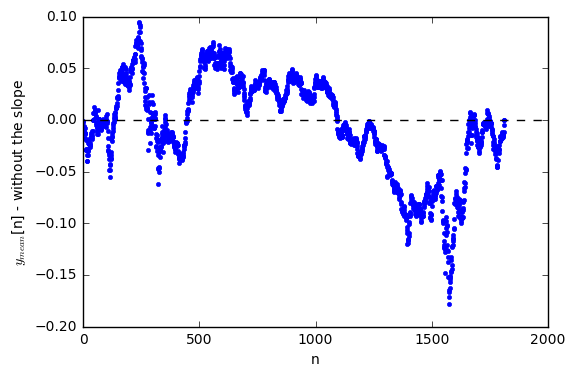

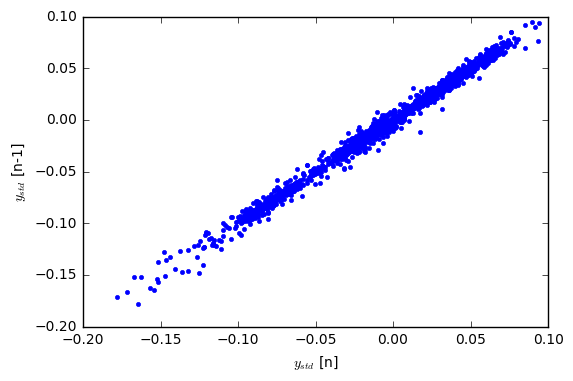

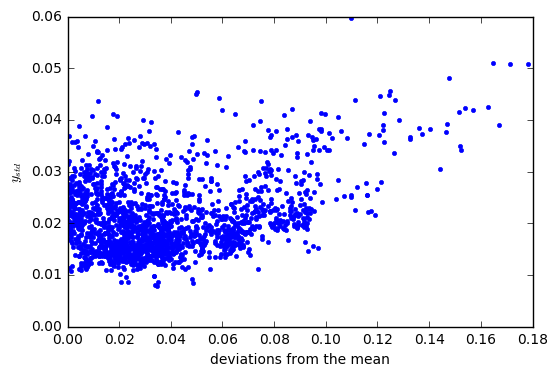

In [11]:
dev = yMeanCumsum - np.mean(yMean)*n

plt.figure()
plt.plot(n, dev, '.')
plt.axhline(color='black', ls='--')
plt.xlabel('n')
plt.ylabel('$y_{mean}$[n] - without the slope')

plt.figure()
plt.plot(dev[1:], dev[:-1], '.')
plt.xlabel('$y_{std}$ [n]')
plt.ylabel('$y_{std}$ [n-1]')

plt.figure()
plt.plot(np.abs(dev), yStd, '.')
plt.xlabel('deviations from the mean')
plt.ylabel('$y_{std}$')

In [12]:
def getScore(slope):
    rewards = []
    print(slope)
    env = kagglegym.make()
    observation = env.reset()

    while True:
        target    = observation.target
        timestamp = observation.features["timestamp"][0]
        target['y'] = slope

        observation, reward, done, info = env.step(target)
        rewards.append(reward)
        if done: break
            
    return info['public_score'], rewards

0.0001182
0.000184866666667
0.000251533333333
0.0003182


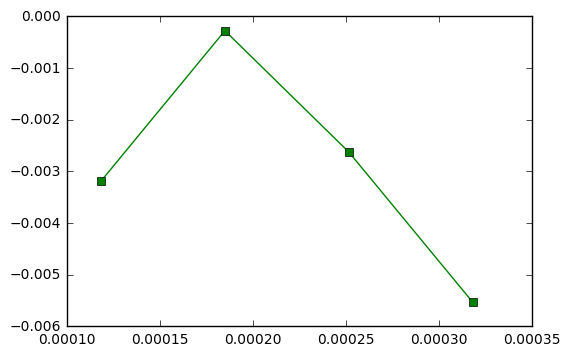

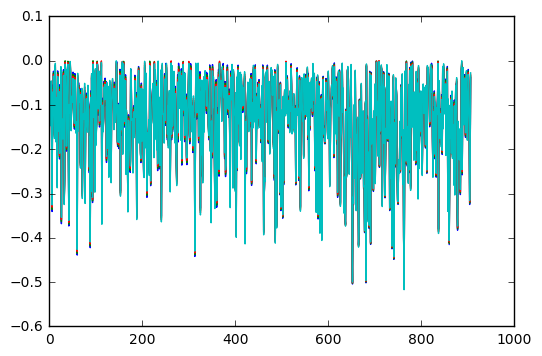

In [15]:
slope = 0.0002182
x1 = np.linspace(slope - 0.0001, slope+0.0001 , 4)
y1 = [ getScore(m) for m in x1 ]
y1, rewards = zip(*y1)

plt.plot(x1, y1, 's-', color='green', mfc='green', mec='black')
plt.figure()
for r in rewards:
    plt.plot(r)

I have to figure out what this rewards this is 

In [18]:
list(map(np.mean, rewards))

[-0.13488033791657561,
 -0.13496289127409436,
 -0.13513102918353911,
 -0.13536892803766068]

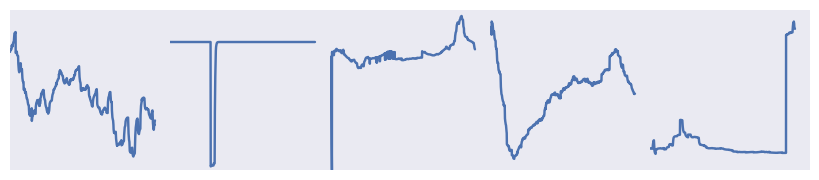

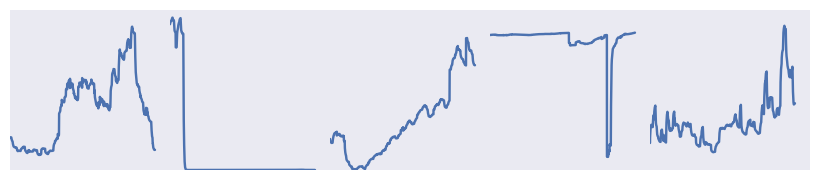

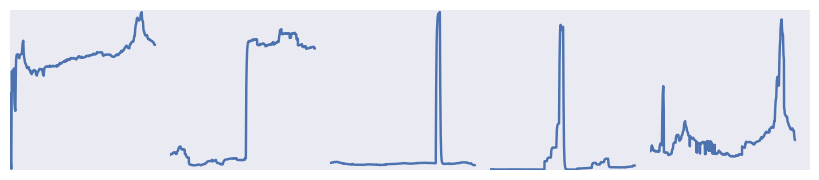

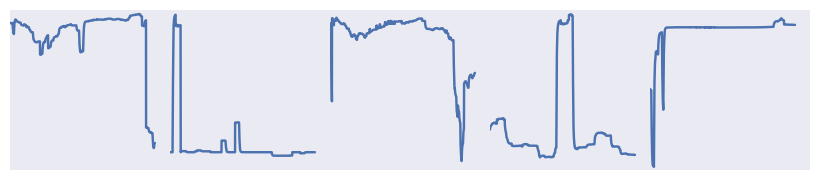

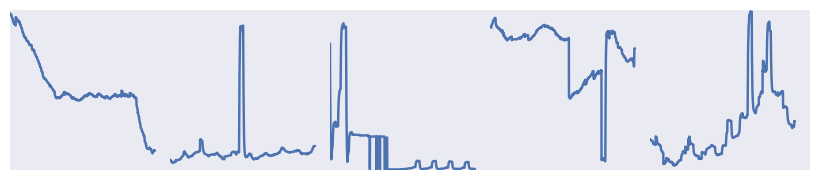

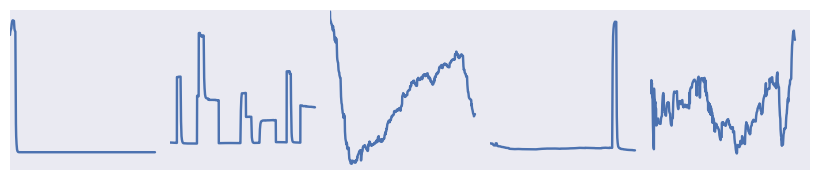

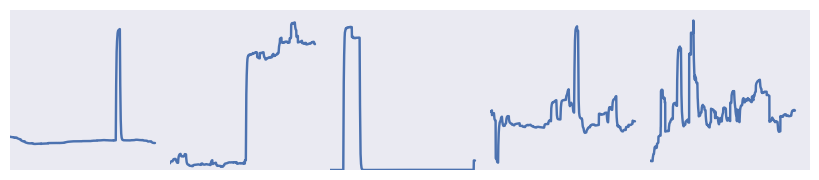

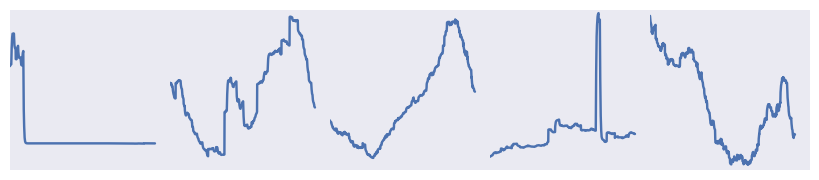

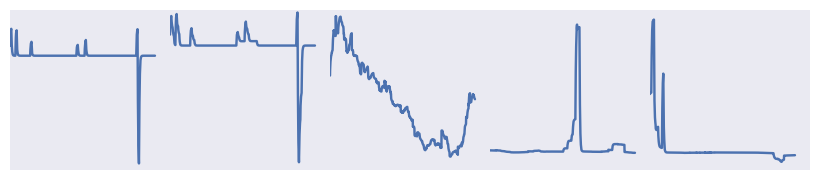

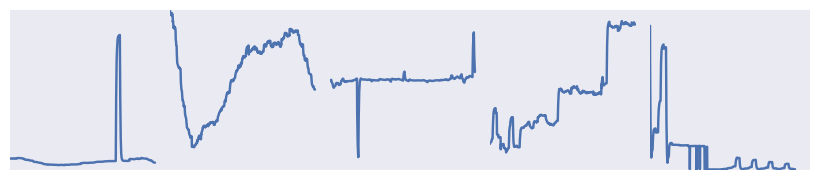

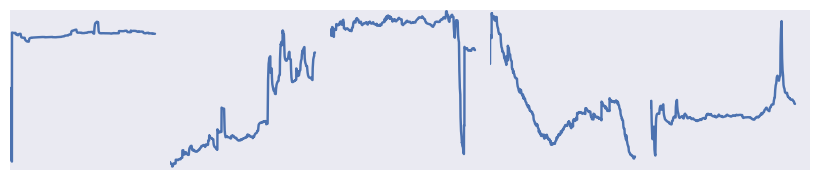

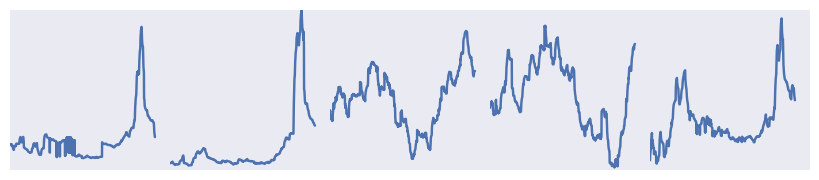

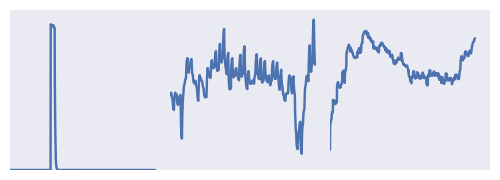

In [19]:
columns = [c for c in df.columns if 'fundamental' in c]
columns1 = columns + ['timestamp']
df2 = df[columns1].groupby('timestamp').agg([np.mean]).reset_index()

i = 0; N=5
while True:
    
    if i >= len(columns): break
    for j in range(N):    
        if i >= len(columns): break
        
        if j == 0:
            plt.figure(figsize=(8,8.0/N))
        
        plt.axes([j*1.0/N,0,1.0/N,1])
        plt.plot(df2['timestamp'], df2[ columns[i] ])
        plt.xticks([]); plt.yticks([])
        i += 1 

Looks like there are a lot of features which correspond very closely to each other. Also, some of them are correlated to the cumulative sum. We want to check if there is some sort of correlation between the different values of fundamental, and y

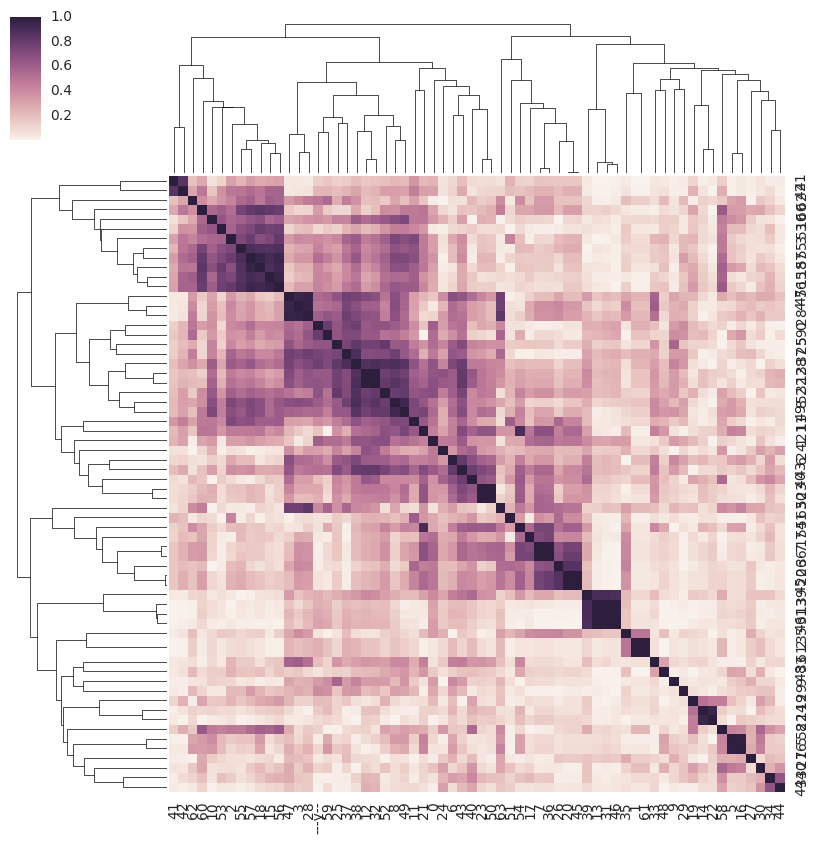

In [20]:
import seaborn as sns
corrColumns = [c for c in df2.columns if 'timestamp'not in c]
fundamentals = np.array([df2[c] for c in corrColumns])
Corr = np.corrcoef( dev, fundamentals )
sns.clustermap( pd.DataFrame(np.abs(Corr), columns=['---y--']+[c[0].split('_')[1] for c in corrColumns]) )

A whole lot of stuff is correlated to the deviation form the mean. This is what we are trying to predict. 